In [7]:
# Import libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import psycopg2
import os
from dotenv import load_dotenv

In [8]:
# Connect to postgis database, read in tables as geopandas geodataframes
load_dotenv()

conn = psycopg2.connect(dbname="spatial_db", user=os.getenv('DB_USERNAME'), password=os.getenv('DB_PASSWORD'), host="localhost", port="5432")

states_query = 'SELECT * FROM "States";'
parcels_query = 'SELECT * FROM "Missoula_Parcels";'
nwa_query = 'SELECT * FROM "National_Wilderness_Areas";'
trails_query = 'SELECT * FROM "Trails";'

states_gdf = gpd.read_postgis(states_query, conn, geom_col="geom")
parcels_gdf = gpd.read_postgis(parcels_query, conn, geom_col="geom")
nwa_gdf = gpd.read_postgis(nwa_query, conn, geom_col="geom")
trails_gdf = gpd.read_postgis(trails_query, conn, geom_col="geom")

conn.close()

C:\Users\mcluck\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\geopandas\io\sql.py:185: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(
C:\Users\mcluck\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\geopandas\io\sql.py:473: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(spatial_ref_sys_sql, con)


In [ ]:
# Select Montana from States GDF, set all GDF to EPSG 6514, subset nwa_gdf to only Montana
montana_gdf = states_gdf[states_gdf["state"] == 'MT']
montana_gdf = montana_gdf.to_crs(epsg=6514)
trails_gdf = trails_gdf.to_crs(epsg=6514)
nwa_gdf = nwa_gdf.to_crs(epsg=6514)
nwa_montana_gdf = gpd.overlay(nwa_gdf, montana_gdf, how="intersection")

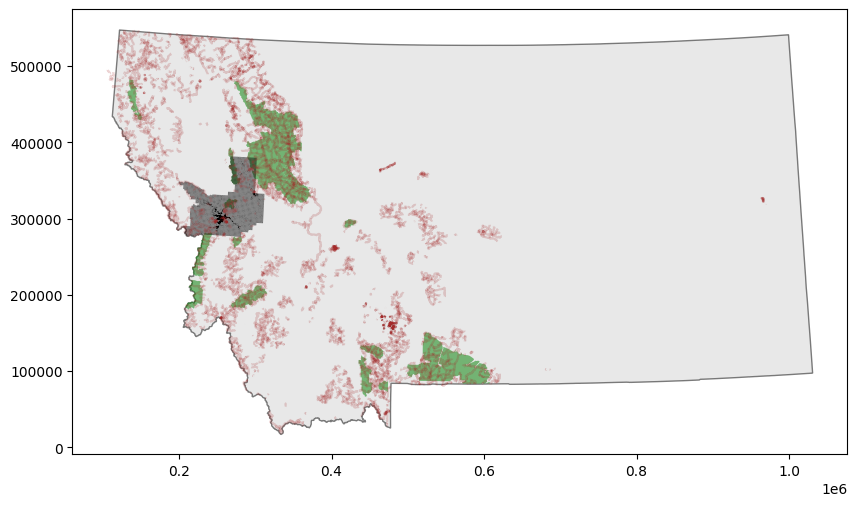

In [ ]:
# Map montana_gdf, trails_gdf, and parcels_gdf to validate CRS
fig, ax = plt.subplots(figsize=(10, 10))

montana_gdf.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)
nwa_montana_gdf.plot(ax=ax, color='green', alpha=0.5)
trails_gdf.plot(ax=ax, color='brown', alpha=0.2)
parcels_gdf.plot(ax=ax, color='black', alpha=0.5)

plt.show()

In [37]:
# Select only NWA polygons and trails intersecting Missoula county
trails_missoula_gdf = gpd.overlay(trails_gdf, parcels_gdf, how="intersection")
nwa_missoula_gdf = gpd.overlay(nwa_gdf, parcels_gdf, how="intersection")

In [44]:
nwa_missoula_gdf.head()

,id_1,WILDERNESSNAME,GIS_ACRES,AREAID,BOUNDARYSTATUS,OBJECTID,WID,SHAPE.LEN,SHAPE.AREA,id_2,...,owneradd_1,owneradd_2,ownercity,ownerstate,ownerzipco,dbaname,careoftaxp,shape_leng,shape_area,geometry
0,41,Bob Marshall Wilderness,1064092.326,049,Final,363047,64.0,5.125782,0.515832,50481,...,26 FORT MISSOULA RD,None,MISSOULA,MT,59804-7203,None,None,6441.726674,2.593393e+06,"POLYGON ((295219.782 368859.371, 296822.872 36..."
1,41,Bob Marshall Wilderness,1064092.326,049,Final,363047,64.0,5.125782,0.515832,50385,...,26 FORT MISSOULA RD,None,MISSOULA,MT,59804-7203,None,None,6346.033848,2.590828e+06,"POLYGON ((299118.058 352481.133, 299112.376 35..."
2,41,Bob Marshall Wilderness,1064092.326,049,Final,363047,64.0,5.125782,0.515832,50389,...,26 FORT MISSOULA RD,None,MISSOULA,MT,59804-7203,None,None,4861.474755,9.907281e+05,"POLYGON ((299101.781 352587.014, 299102.091 35..."
3,41,Bob Marshall Wilderness,1064092.326,049,Final,363047,64.0,5.125782,0.515832,50392,...,26 FORT MISSOULA RD,None,MISSOULA,MT,59804-7203,None,None,6238.729765,2.525577e+06,"POLYGON ((298112.691 354237.845, 298099.248 35..."
4,41,Bob Marshall Wilderness,1064092.326,049,Final,363047,64.0,5.125782,0.515832,50402,...,26 FORT MISSOULA RD,None,MISSOULA,MT,59804-7203,None,None,5957.956450,2.200634e+06,"POLYGON ((299439.339 355725.393, 299515.681 35..."


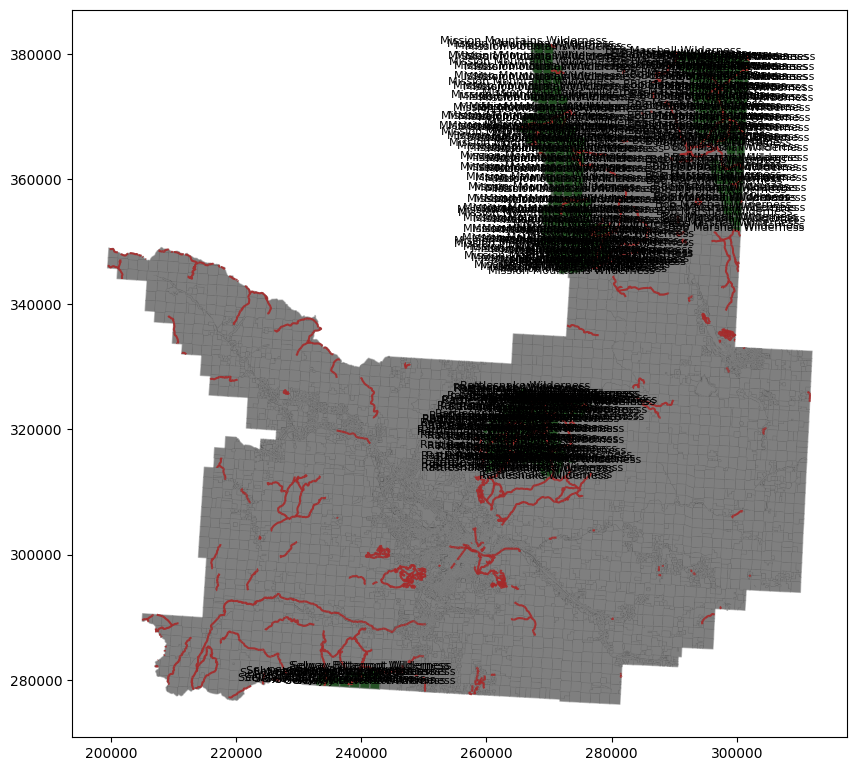

In [45]:
# Plot newly subsetted data

fig, ax = plt.subplots(figsize=(10, 10))

# Add labels for each feature
for idx, row in nwa_missoula_gdf.iterrows():
    ax.annotate(text=row["WILDERNESSNAME"],  # Replace "NAME" with the column you want to use as labels
                xy=(row.geometry.centroid.x, row.geometry.centroid.y), 
                ha='center', fontsize=8, color='black')

nwa_missoula_gdf.plot(ax=ax, color='green', alpha=0.7)
trails_missoula_gdf.plot(ax=ax, color='brown', alpha=0.9)
parcels_gdf.plot(ax=ax, color='black', edgecolor='gray', alpha=0.5)

plt.show()